In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import datetime
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import ParameterGrid

## Download dos dados

In [2]:
start_date = datetime.datetime(2018, 1, 1)
end_date = datetime.datetime(2021, 1, 1)
stock = 'EURUSD=X'

ma_period = 60
period = 14

In [3]:
ticker = yf.download(stock, start_date, end_date)
data = pd.DataFrame(ticker)

[*********************100%***********************]  1 of 1 completed


In [4]:
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-01,1.200495,1.201504,1.199904,1.200495,1.200495,0
2018-01-02,1.201086,1.208094,1.200855,1.201158,1.201158,0
2018-01-03,1.206200,1.206709,1.200495,1.206345,1.206345,0
2018-01-04,1.201129,1.209190,1.200495,1.201043,1.201043,0
2018-01-05,1.206622,1.208459,1.202154,1.206884,1.206884,0
...,...,...,...,...,...,...
2020-12-28,1.220703,1.225200,1.218353,1.220510,1.220510,0
2020-12-29,1.222001,1.227599,1.222001,1.222345,1.222345,0
2020-12-30,1.225325,1.230875,1.225205,1.225295,1.225295,0


## Construção dos sinais

In [5]:
# média móvel
data['SMA'] = data['Close'].rolling(window=ma_period).mean()

# tendência
data['trend'] = (data['Open'] - data['SMA']) * 100

# Relative Strength Indicator
data['move'] = data['Close'] - data['Close'].shift(1)
data['up'] = np.where(data['move'] > 0, data['move'], 0)
data['down'] = np.where(data['move'] < 0, data['move'], 0)
data['average_gain'] = data['up'].rolling(period).mean()
data['average_loss'] = data['down'].abs().rolling(period).mean()
data['relative_strength'] = data['average_gain'] / data['average_loss']
rsi = 100.0 - (100.0 / (1.0 + data['relative_strength']))
data['RSI'] = rsi / 100 # features with same order

# Average True Range
high_low = data['High'] - data['Low']
high_close = np.abs(data['High'] - data['Close'].shift())
low_close = np.abs(data['Low'] - data['Close'].shift())

ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_ranges = np.max(ranges, axis=1)

data['ATR'] = true_ranges.rolling(14).mean() # true_ranges.rolling(14).sum() / 14

# Boillinger Bands
data['tp'] = (data['Close'] + data['Low'] + data['High']) / 3
data['std'] = data['tp'].rolling(20).std()
data['ma'] = data['tp'].rolling(20).mean()
data['upper_band'] = data['ma'] + 2 * data['std']
data['lower_band'] = data['ma'] - 2 * data['std']

data['boillinger'] = np.where(data['Close']  > data['upper_band'], 1, -1)

# Crossover Strategy
data['short_ma'] = data['Close'].ewm(span=30).mean()
data['long_ma'] = data['Close'].ewm(span=50).mean()
data['crossover'] = np.where(data['short_ma']  > data['long_ma'], 1, -1)

# variável de saída - subida = 1, descida = -1
data['direction'] = np.where(data['Close'] - data['Open'] > 0, 1, -1)

# remoção dos valores nan
currency_data = data.dropna()

In [6]:
currency_data

,Open,High,Low,Close,Adj Close,Volume,SMA,trend,move,up,...,tp,std,ma,upper_band,lower_band,boillinger,short_ma,long_ma,crossover,direction
Date,,,,,,,,,,,,,,,,,,,,,
2018-03-23,1.232605,1.236017,1.231997,1.232499,1.232499,0,1.227856,0.474909,-0.002268,0.000000,...,1.233504,0.005446,1.231761,1.242654,1.220868,-1,1.232415,1.231604,1,-1
2018-03-26,1.235391,1.244896,1.235239,1.235437,1.235437,0,1.228438,0.695334,0.002939,0.002939,...,1.238524,0.005645,1.232146,1.243436,1.220856,-1,1.232613,1.231769,1,1
2018-03-27,1.245501,1.247816,1.237333,1.245749,1.245749,0,1.229181,1.631935,0.010312,0.010312,...,1.243633,0.006157,1.232854,1.245168,1.220539,1,1.233474,1.232367,1,1
2018-03-28,1.240803,1.242236,1.233715,1.240787,1.240787,0,1.229755,1.104716,-0.004962,0.000000,...,1.238913,0.005744,1.233695,1.245182,1.222208,-1,1.233953,1.232726,1,-1
2018-03-29,1.231284,1.233806,1.228516,1.231027,1.231027,0,1.230255,0.102940,-0.009760,0.000000,...,1.231116,0.004652,1.234299,1.243604,1.224995,-1,1.233762,1.232654,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-28,1.220703,1.225200,1.218353,1.220510,1.220510,0,1.191874,2.882920,0.002038,0.002038,...,1.221354,0.006225,1.215288,1.227738,1.202838,-1,1.207955,1.199992,1,-1
2020-12-29,1.222001,1.227599,1.222001,1.222345,1.222345,0,1.192592,2.940871,0.001835,0.001835,...,1.223982,0.004941,1.216607,1.226489,1.206725,-1,1.208883,1.200868,1,1
2020-12-30,1.225325,1.230875,1.225205,1.225295,1.225295,0,1.193451,3.187389,0.002951,0.002951,...,1.227125,0.004977,1.217593,1.227547,1.207638,-1,1.209942,1.201826,1,-1


## Machine learning - Support Vector Machine

In [7]:
X = currency_data[['trend', 'RSI', 'ATR', 'boillinger', 'crossover']]
y = currency_data['direction']

In [8]:
# separação dos dados em teste e treino (30% - 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [9]:
# grid search para encontrar os melhores hiperparâmetros do modelo SVC
parameters = {'gamma': [10, 1, 0.1, 0.01, 0.001],
             'C': [1, 10, 100, 1000, 10000]}
grid = list(ParameterGrid(parameters))

best_accuracy = 0
best_parameter = None

for p in grid:
    model = SVC(C=p['C'], gamma=p['gamma'])
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print('Acurácia do modelo: %.4f' % accuracy)
    
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_parameter = p

print('Melhores hiperparâmetros')
print(best_accuracy)
print(best_parameter)

Acurácia do modelo: 0.5780
Acurácia do modelo: 0.5642
Acurácia do modelo: 0.5826
Acurácia do modelo: 0.6147
Acurácia do modelo: 0.6147
Acurácia do modelo: 0.5367
Acurácia do modelo: 0.5734
Acurácia do modelo: 0.5780
Acurácia do modelo: 0.6055
Acurácia do modelo: 0.6147
Acurácia do modelo: 0.5092
Acurácia do modelo: 0.5642
Acurácia do modelo: 0.5734
Acurácia do modelo: 0.5780
Acurácia do modelo: 0.6147
Acurácia do modelo: 0.4725
Acurácia do modelo: 0.5596
Acurácia do modelo: 0.5459
Acurácia do modelo: 0.5917
Acurácia do modelo: 0.6055
Acurácia do modelo: 0.5229
Acurácia do modelo: 0.5642
Acurácia do modelo: 0.5550
Acurácia do modelo: 0.5826
Acurácia do modelo: 0.5780
Melhores hiperparâmetros
0.6146788990825688
{'C': 1, 'gamma': 0.01}


In [10]:
model = SVC(C=best_parameter['C'], gamma=best_parameter['gamma'])
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print('Acurácia do modelo: %.2f' % accuracy_score(y_test, predictions))
print(confusion_matrix(predictions, y_test))

Acurácia do modelo: 0.61
[[  0   0]
 [ 84 134]]


In [11]:
# quantos valores temos de subida e descida
y.value_counts()

 1    423
-1    302
Name: direction, dtype: int64

<AxesSubplot:xlabel='Date'>

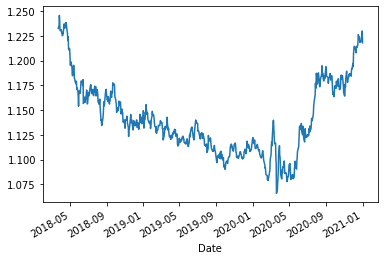

In [12]:
currency_data['Adj Close'].plot()

## Machine Learning - RandomForest

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
model = RandomForestClassifier()

In [15]:
model.fit(X_train, y_train)
predictions = model.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print(accuracy)

0.48623853211009177
